# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program. We also demonstrate a possible solution for the second project.


### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

We will use here the headless version since the project is set up in a dockerized environment to execute it on remote computing (possible GPU enabled)
resources as well. 


Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
``


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import pickle
import torch
import os

from unityagents import UnityEnvironment
from collections import deque
from ddpg_agent import Agent
from ddpg_utils import ddpg_train, ddpg_present, plot_experiment

sns.set()
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
env = UnityEnvironment(file_name="../Reacher2_Linux_NoVis/Reacher.x86_64")
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment note: train_mode is True since we would like to train our agent here
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print("Number of agents:", num_agents)

# size of each action
action_size = brain.vector_action_space_size
states = env_info.vector_observations
state_size = states.shape[1]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Number of agents: 20


### 2. Train the agent with DDPG

During the assigment we train the agent with `Deep Deterministic Policy Gradient` algorithm. You can find an outstanding description about it 
[here](https://spinningup.openai.com/en/latest/algorithms/ddpg.html). The underlying deep(? - maybe rather wide than deep) neural networks for the actor and the critic are defined in [model.py](./model.py). The agent itself in the [ddpg_agent.py](./ddpg_agent.py). These implementations are based on the examples provided for the course for the actor-critic methods chapter [here](https://github.com/udacity/deep-reinforcement-learning/tree/master/ddpg-bipedal) or [here](https://github.com/udacity/deep-reinforcement-learning/tree/master/ddpg-pendulum). 

I choose to solve the second version with 20 agents as: the task is episodic, and in order to solve the environment, the agents need get an average score of +30 over 100 consecutive episodes.

Next we define the hyperparams we would like to use and compare the convergence applying them. 

In [3]:
agent_params = {
    "ACTOR_HIDDEN_LAYERS": [400, 300],
    "CRITIC_HIDDEN_LAYERS": [400, 300],
    "USE_BATCH_NORM": True,
    "ADD_NOISE": True,
    "GRAD_CLIP": False,
    "BUFFER_SIZE": int(1e5),
    "BATCH_SIZE": 128,
    "GAMMA": 0.99,
    "TAU": 1e-3,
    "LR_ACTOR": 1e-4,
    "LR_CRITIC": 1e-4,
    "WEIGHT_DECAY": 0,
    "UPDATE_EVERY": 1,
    "UPDATE_FREQ": 1,
    "USE_XAVIER": False,
}
agent_params1 = {**agent_params,
                 "ACTOR_HIDDEN_LAYERS": [400, 300, 200, 100],
                 "CRITIC_HIDDEN_LAYERS": [400, 300, 200, 100],
                 }

agent_params2 = {**agent_params,
                 "LR_CRITIC": 1e-3,}
agent_params3 = {**agent_params1,
                 "LR_CRITIC": 1e-3,}

{'ACTOR_HIDDEN_LAYERS': [400, 300], 'CRITIC_HIDDEN_LAYERS': [400, 300], 'USE_BATCH_NORM': True, 'ADD_NOISE': True, 'GRAD_CLIP': False, 'BUFFER_SIZE': 100000, 'BATCH_SIZE': 128, 'GAMMA': 0.99, 'TAU': 0.001, 'LR_ACTOR': 0.0001, 'LR_CRITIC': 0.0001, 'WEIGHT_DECAY': 0, 'UPDATE_EVERY': 1, 'UPDATE_FREQ': 1, 'USE_XAVIER': False}
Episode 5	Average Score: 0.95	Max Score: 1.56	Std Score: 0.35
Episode 10	Average Score: 1.35	Max Score: 2.63	Std Score: 0.58
Episode 15	Average Score: 2.21	Max Score: 4.79	Std Score: 1.39
Episode 20	Average Score: 3.84	Max Score: 15.24	Std Score: 3.71
Episode 25	Average Score: 8.49	Max Score: 34.57	Std Score: 10.10
Episode 30	Average Score: 13.08	Max Score: 37.17	Std Score: 13.80
Episode 35	Average Score: 16.57	Max Score: 37.89	Std Score: 15.38
Episode 40	Average Score: 19.13	Max Score: 37.89	Std Score: 15.90
Episode 45	Average Score: 21.13	Max Score: 37.89	Std Score: 16.02
Episode 50	Average Score: 22.68	Max Score: 37.89	Std Score: 15.90
Episode 55	Average Score: 23.

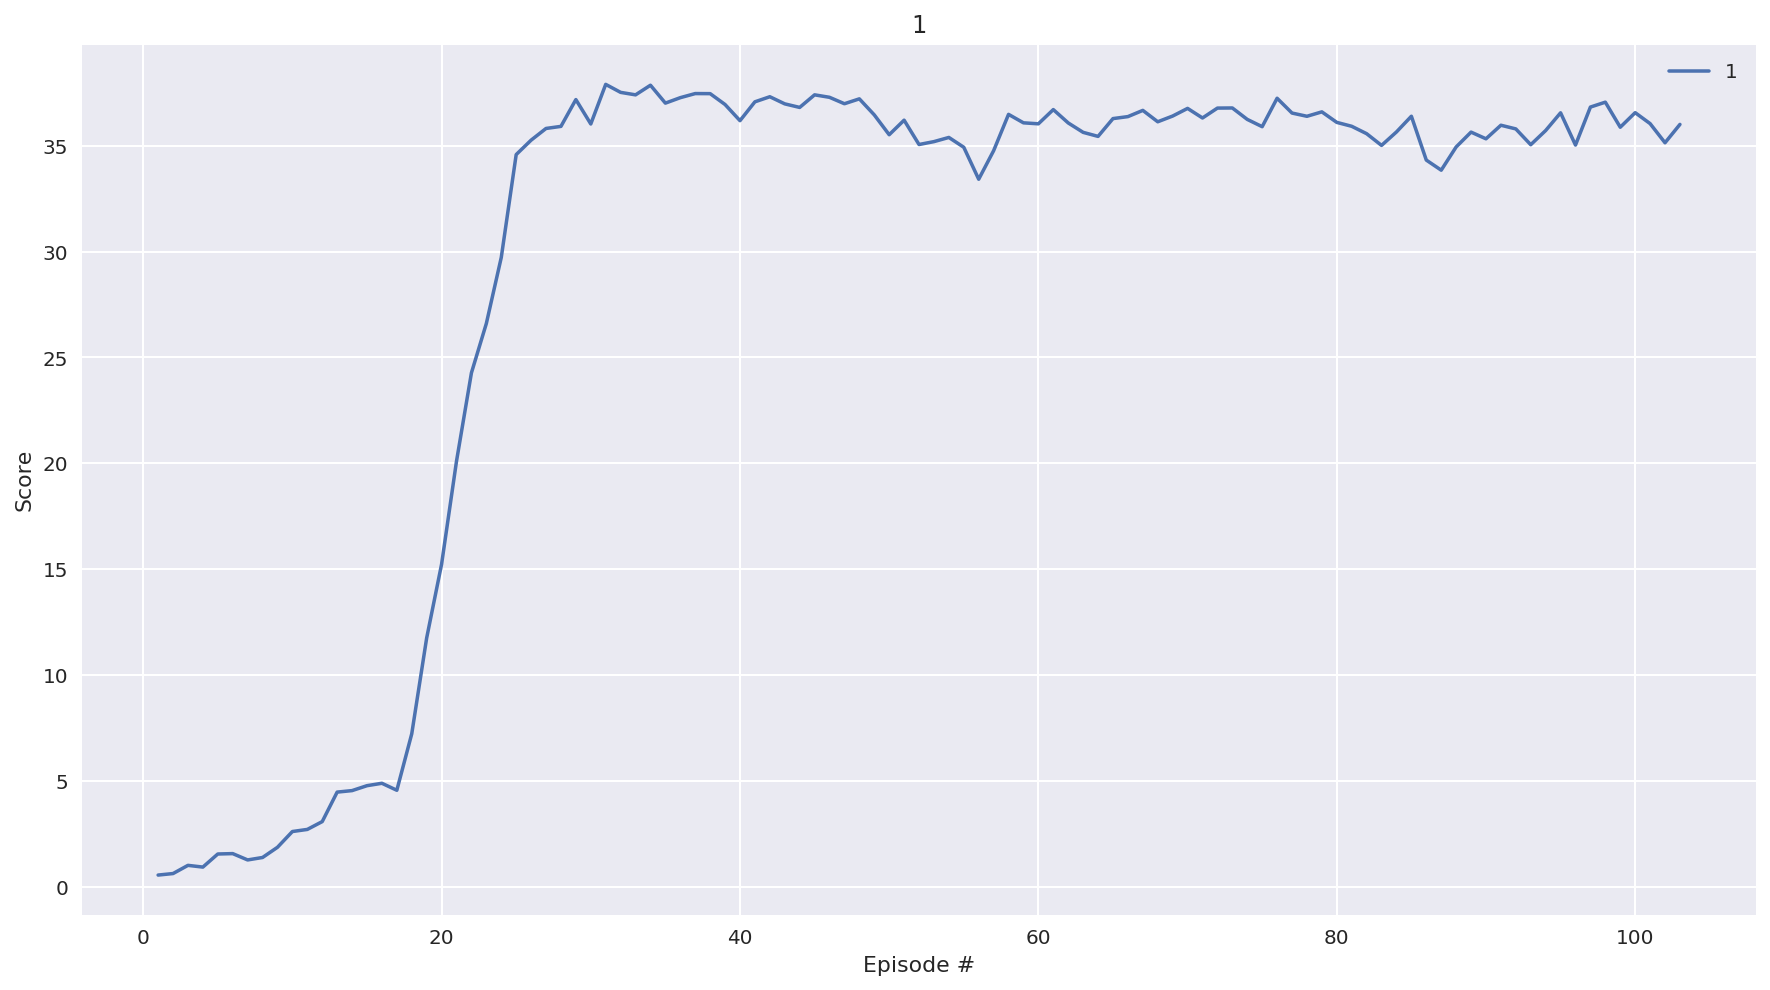

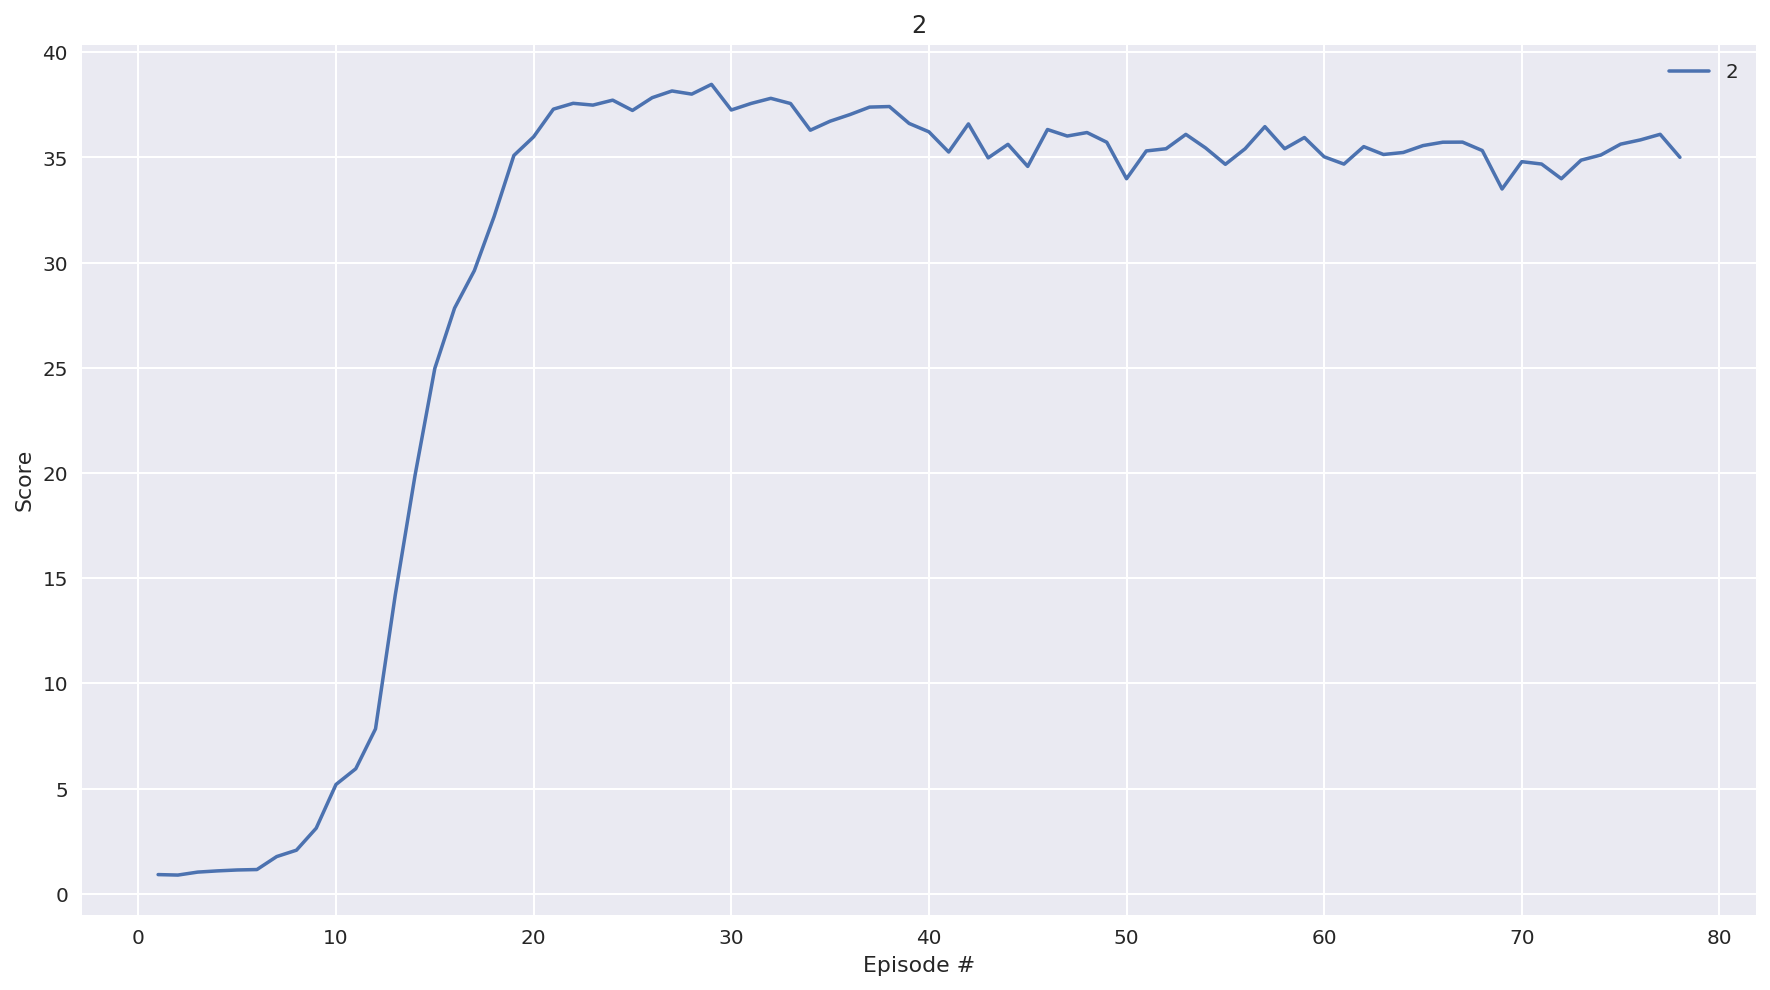

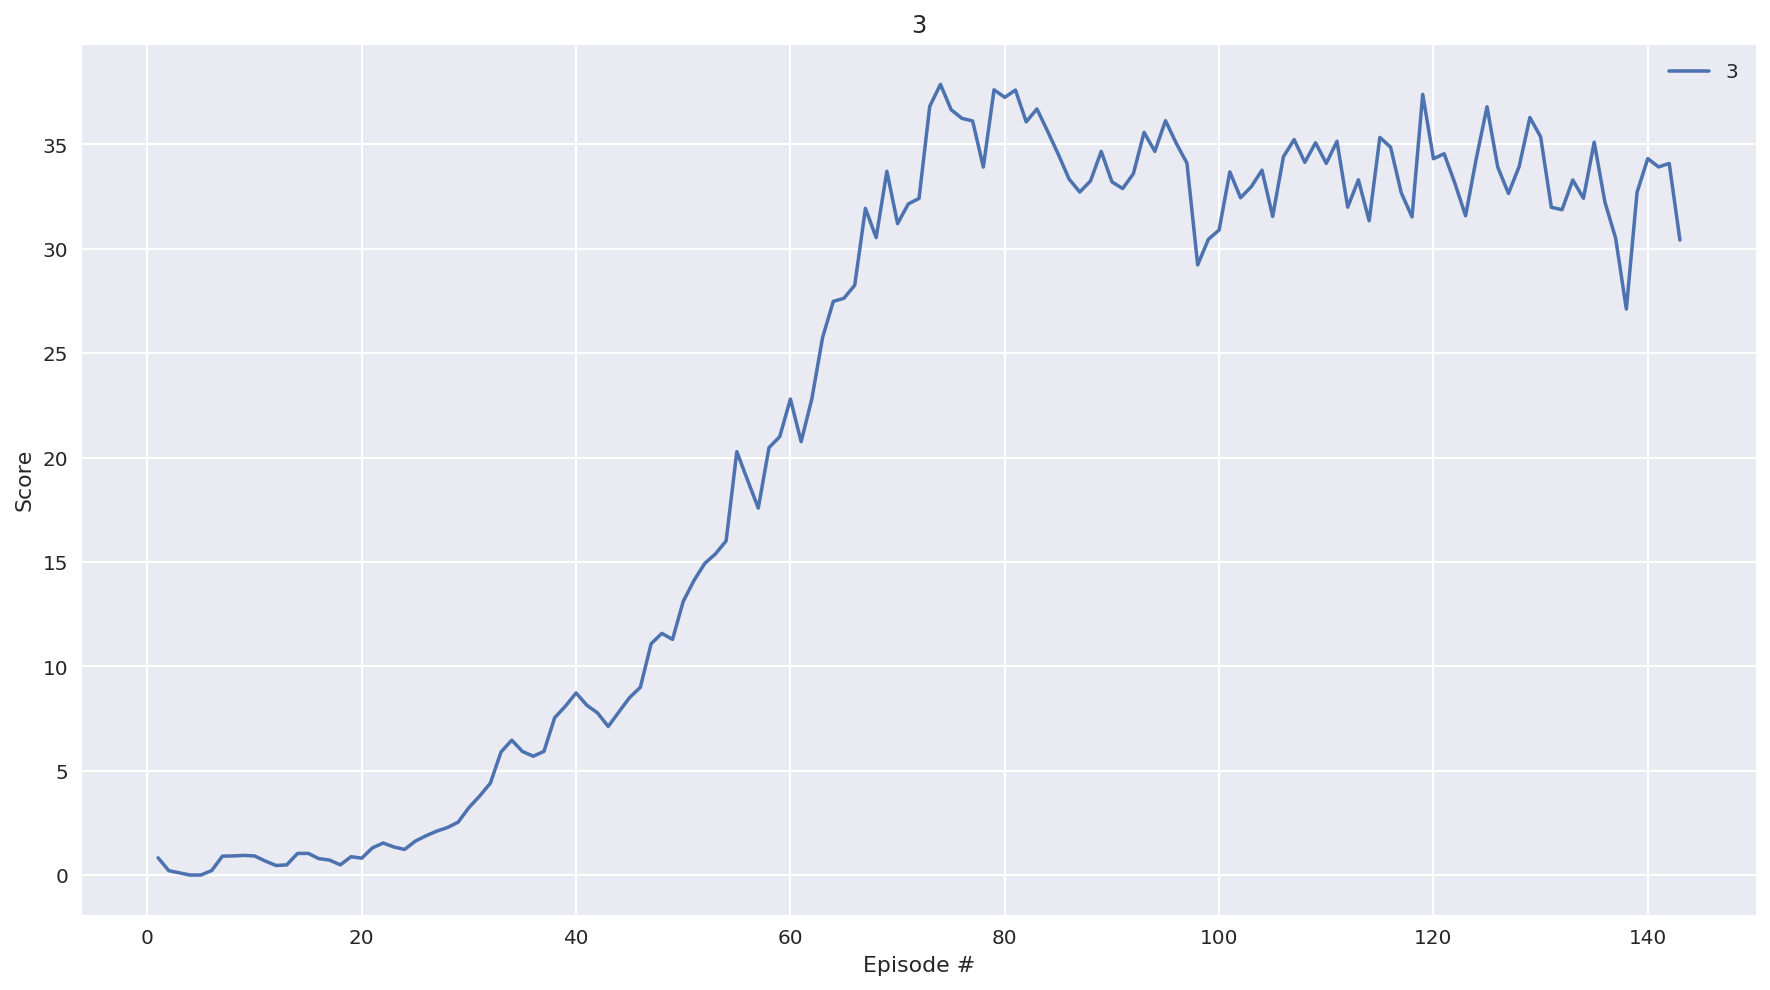

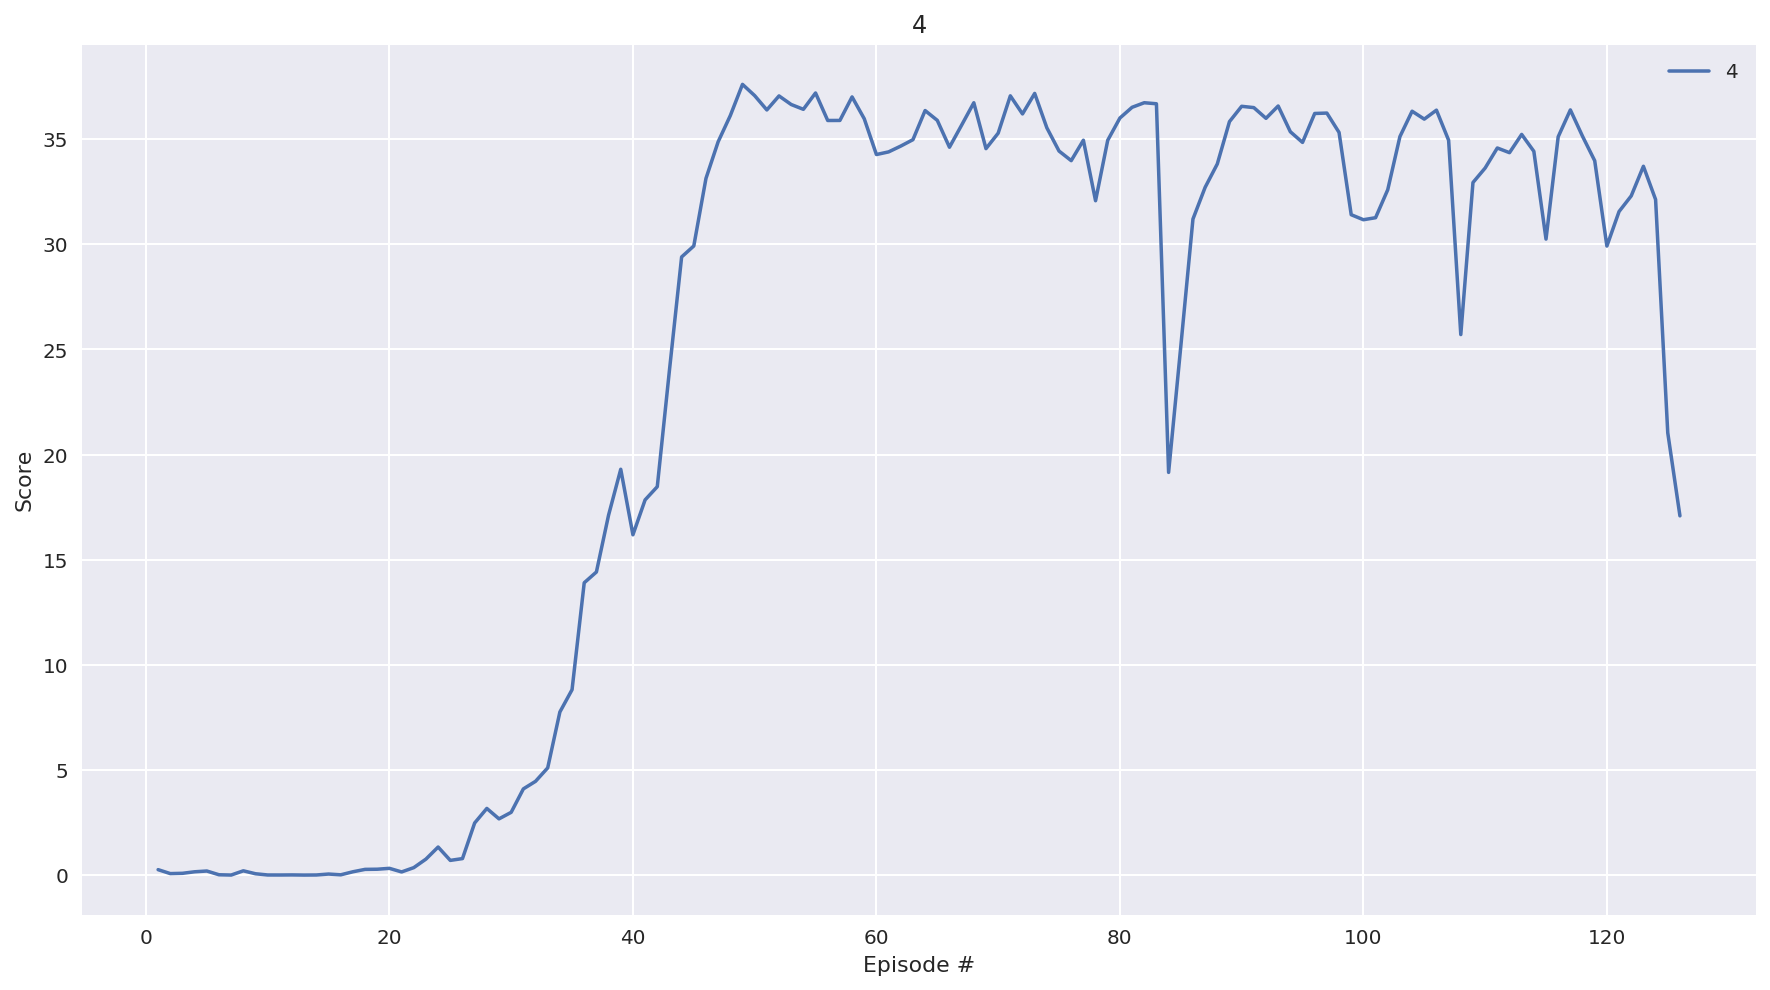

In [4]:
experiments = [agent_params, agent_params1, agent_params2, agent_params3]
exp_count=1
for exp in experiments:
    print(exp)
    folder = "./experiments/"
    os.makedirs(folder, exist_ok=True)

    with open(folder  +'/exp_' + str(exp_count) + '.json', 'w') as fp:
        json.dump(exp, fp)
    agent = Agent(state_size, action_size, num_agents, 42, exp)
    scores = ddpg_train(agent, env, brain_name, num_agents,
                         actor_model_pth= folder + 'actor_model_exp_'+str(exp_count) +'.pth',
                        critic_model_pth=folder + 'critic_model_exp_'+str(exp_count) +'.pth',
					        n_episodes=1500,  print_every=5)
    with open(folder +'/exp_' + str(exp_count) + '_scores.pkl', 'wb') as fp:
        pickle.dump(scores, fp, protocol=pickle.HIGHEST_PROTOCOL)
    plot_experiment(scores, exp_count)
    exp_count += 1

### 3. Comparison of the executed experiments

Below you can see the effect of the previous experiments on the convergence.

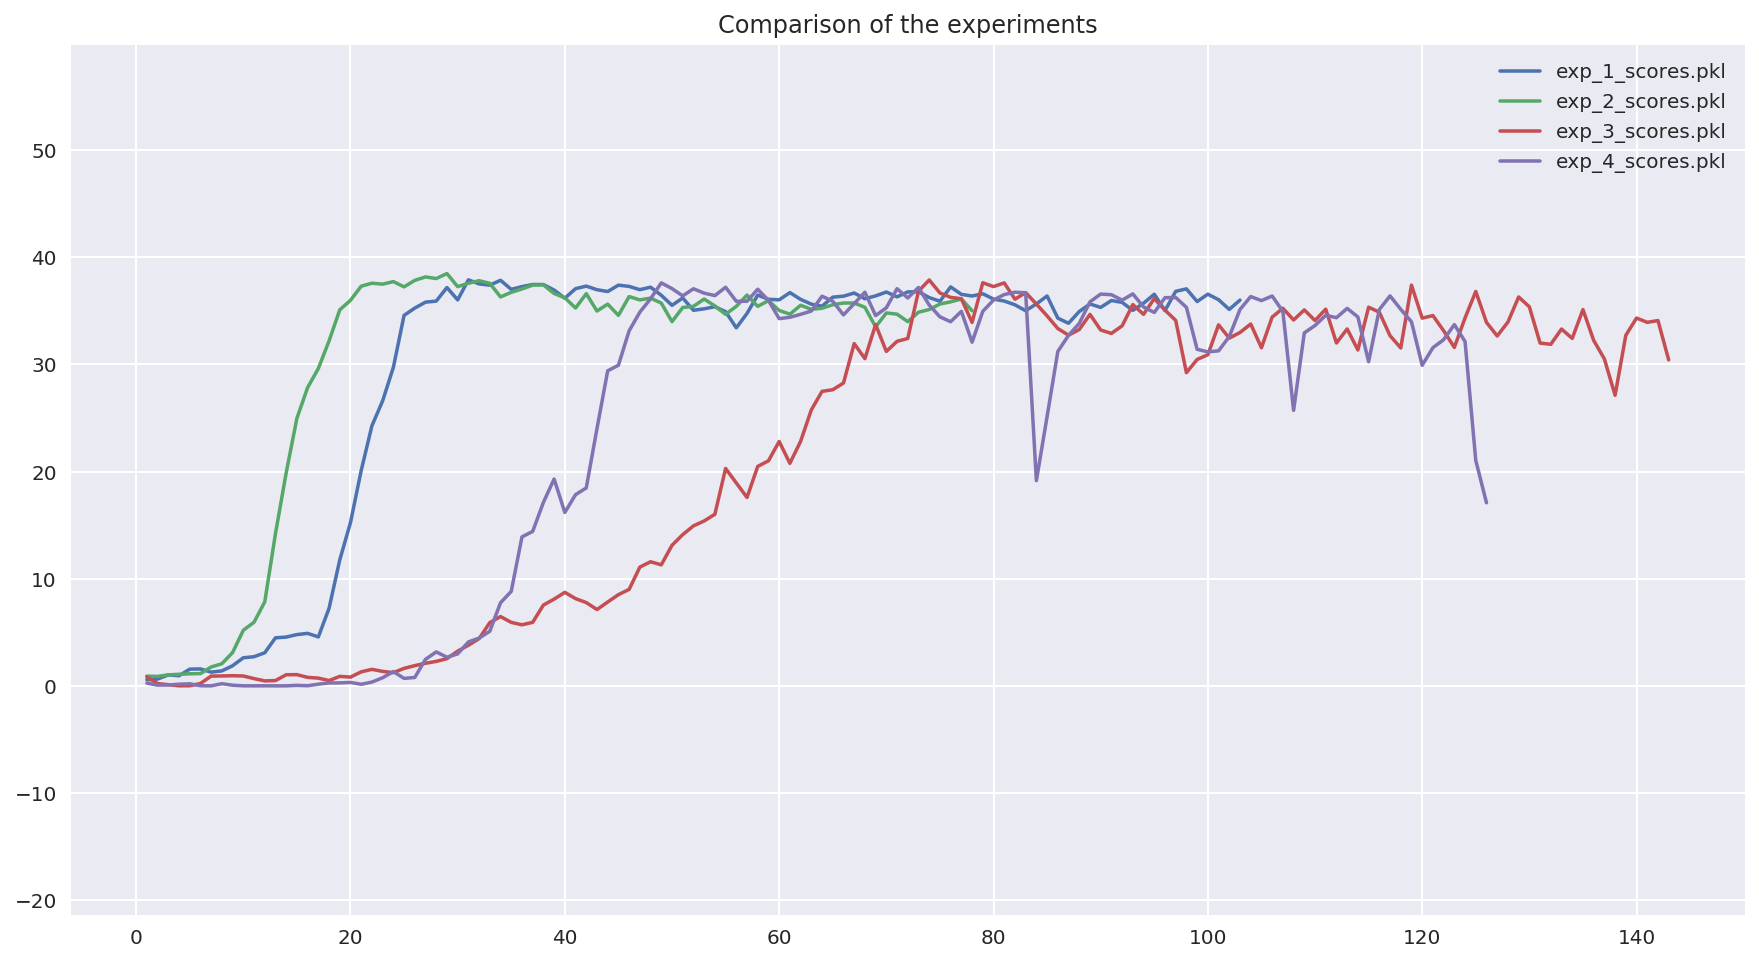

In [5]:
folder = "./experiments/"
plt.figure(figsize=(15, 8))
for file in os.listdir(folder):
    if file.endswith(".pkl"):
        with open(folder + file, 'rb') as fp:
            scores = pickle.load(fp)
            plt.plot(np.arange(1, len(scores) + 1), np.squeeze(np.vstack(scores)), label=str(file))
plt.axis('equal');
plt.title('Comparison of the experiments')
plt.legend();
plt.savefig("./experiments/comparison.png")

### 4. Present a previously trained agent 

In [7]:
exp_id = 1 # set id of experiment to present...
folder = "./experiments/"
agent = Agent(state_size, action_size, num_agents, 42, agent_params)
ddpg_present(agent, env, brain_name, num_agents,
                         actor_model_pth= folder + "actor_model_exp_" + str(exp_id) + ".pth",
                        critic_model_pth=folder + "critic_model_exp_" + str(exp_id) + ".pth")

Mean Score (for all the agents): 35.626999203674494
Score for individual agents:
[37.77999916 37.24999917 37.14999917 37.20999917 32.85999927 38.76999913
 35.8999992  33.67999925 37.45999916 37.32999917 36.54999918 35.6699992
 34.86999922 36.0099992  31.57999929 30.83999931 32.73999927 34.55999923
 37.16999917 37.15999917]
